<a href="https://colab.research.google.com/github/Livia-Rose/ML/blob/main/lauvain_modularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Replace with your actual file name
df = pd.read_csv("/content/sample_data/UPI apps transaction data in 2021.csv")
df.head()

,UPI Banks,Volume (Mn) By Costumers,Value (Cr) by Costumers,Volume (Mn),Value (Cr),Month,Year
0,Airtel Payments Bank Apps,9.04,2248.49,15.12,5732.09,12,2021
1,Airtel Payments Bank Apps,8.41,1923.95,15.90,5554.63,11,2021
2,Airtel Payments Bank Apps,7.60,1491.34,14.31,4746.79,10,2021
3,Airtel Payments Bank Apps,6.91,1520.92,11.52,3759.12,9,2021
4,Airtel Payments Bank Apps,6.14,1396.65,9.31,2941.88,8,2021


In [2]:
print(df.columns)

Index(['UPI Banks', 'Volume (Mn) By Costumers', 'Value (Cr) by Costumers',
       'Volume (Mn)', 'Value (Cr)', 'Month', 'Year'],
      dtype='object')


In [3]:
!pip install networkx python-louvain matplotlib

In [4]:
!pip install networkx python-louvain matplotlib scikit-learn

In [8]:
data['Value_per_Volume'] = data['Value (Cr)'] / data['Volume (Mn)']
numerical_features.append('Value_per_Volume')

In [7]:
import networkx.readwrite as nx_rw

In [9]:
print(data.head())
print(data.dtypes)
print(data.isnull().sum())

                   UPI Banks  Volume (Mn) By Costumers  \
0  Airtel Payments Bank Apps                      8.53   
1  Airtel Payments Bank Apps                      5.80   
2  Airtel Payments Bank Apps                      8.33   
3  Airtel Payments Bank Apps                      5.29   
4  Airtel Payments Bank Apps                      6.10   

   Value (Cr) by Costumers  Volume (Mn)  Value (Cr)  Month  Year  \
0                  2047.45        13.22     4729.77      1  2022   
1                  1199.46         7.58     2210.17      2  2022   
2                  1934.41        13.16     4492.25      3  2022   
3                   454.64         5.30      460.90      4  2022   
4                   486.55         6.11      486.62      5  2022   

   UPI Banks_Encoded  Community  Degree  Value_per_Volume  
0                  2          3      12        357.773828  
1                  2          3      12        291.579156  
2                  2          3      12        341.356383  
3 

In [10]:
data_sample = data.sample(frac=0.5, random_state=42)

In [11]:
import pandas as pd
import networkx as nx
from community import community_louvain  # python-louvain library
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Load the dataset from Colab's file system
file_path = '/content/sample_data/UPI apps transaction data in 2021.csv'  # Adjust path if needed
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Define numerical and categorical features
numerical_features = [
    'Volume (Mn) By Costumers', 'Value (Cr) by Costumers',
    'Volume (Mn)', 'Value (Cr)', 'Month', 'Year'
]
categorical_features = ['UPI Banks']

# Convert numerical columns to numeric, handling commas
for col in numerical_features:
    data[col] = pd.to_numeric(data[col].replace(',', '', regex=True), errors='coerce')

# Handle missing values in numerical features
data[numerical_features] = data[numerical_features].fillna(data[numerical_features].median(numeric_only=True))

# Encode categorical feature (UPI Banks)
le = LabelEncoder()
data['UPI Banks_Encoded'] = le.fit_transform(data['UPI Banks'].astype(str))
label_encoders = {'UPI Banks': le}

# Create a network
G = nx.Graph()

# Add nodes (UPI Banks)
unique_banks = data['UPI Banks_Encoded'].unique()
G.add_nodes_from(unique_banks)

# Add edges based on transaction similarity in the same Month/Year
for i, row1 in data.iterrows():
    for j, row2 in data.iterrows():
        if row1['UPI Banks_Encoded'] < row2['UPI Banks_Encoded'] and row1['Month'] == row2['Month'] and row1['Year'] == row2['Year']:
            volume_diff = abs(row1['Volume (Mn)'] - row2['Volume (Mn)']) / max(row1['Volume (Mn)'], row2['Volume (Mn)'], 1)
            value_diff = abs(row1['Value (Cr)'] - row2['Value (Cr)']) / max(row1['Value (Cr)'], row2['Value (Cr)'], 1)
            similarity = 1 / (1 + volume_diff + value_diff)
            if similarity > 0.5:  # Threshold to reduce noise
                G.add_edge(row1['UPI Banks_Encoded'], row2['UPI Banks_Encoded'], weight=similarity)

# Apply Louvain Modularity for community detection
partition = community_louvain.best_partition(G, random_state=42)

# Analyze communities
community_counts = Counter(partition.values())
print("Number of communities:", len(community_counts))
print("Community sizes:", dict(community_counts))

# Add community labels to the dataset
data['Community'] = data['UPI Banks_Encoded'].map(partition)

# Identify potential anomalies (banks in small communities or with low degree)
degrees = dict(G.degree())
data['Degree'] = data['UPI Banks_Encoded'].map(degrees)
small_communities = [k for k, v in community_counts.items() if v < 3]  # Communities with <3 banks
anomalies = data[data['Community'].isin(small_communities) | (data['Degree'] < 2)]

# Decode UPI Banks for anomalies output
anomalies.loc[:, 'UPI Banks'] = label_encoders['UPI Banks'].inverse_transform(anomalies['UPI Banks_Encoded'])
print("\nPotential anomalies (banks in small communities or with low connectivity):")
print(anomalies[['UPI Banks', 'Community', 'Degree', 'Volume (Mn)', 'Value (Cr)']])

# Create a proxy label for evaluation (low Volume (Mn) as anomalies)
y_proxy = (data['Volume (Mn)'] < data['Volume (Mn)'].median()).astype(int)  # 1 for low volume, 0 otherwise
y_pred = (data['Community'].isin(small_communities) | (data['Degree'] < 2)).astype(int)

# Evaluate using proxy labels
print(f"\nROC AUC Score (using low volume as proxy for anomalies): {roc_auc_score(y_proxy, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_proxy, y_pred))

# Save the network and dataset with communities
nx.write_gpickle(G, '/content/upi_network.gpickle')
data['UPI Banks'] = label_encoders['UPI Banks'].inverse_transform(data['UPI Banks_Encoded'])
data.to_csv('/content/UPI_with_communities.csv', index=False)

# Visualize the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=list(partition.values()), cmap=plt.cm.viridis, with_labels=False, node_size=50)
plt.title("UPI Banks Network with Louvain Communities")
plt.savefig('/content/upi_network_communities.png')
plt.show()

Number of communities: 5
Community sizes: {0: 17, 1: 30, 3: 19, 4: 2, 2: 1}

Potential anomalies (banks in small communities or with low connectivity):
                   UPI Banks  Community  Degree  Volume (Mn)  Value (Cr)
252               Google Pay          4       1      1587.43   302989.79
253               Google Pay          4       1      1447.84   283357.99
254               Google Pay          4       1      1451.93   287491.46
255               Google Pay          4       1      1294.56   250393.65
256               Google Pay          4       1      1243.75   244453.05
257               Google Pay          4       1      1119.16   230847.54
258               Google Pay          4       1       972.26   207287.73
259               Google Pay          4       1       880.59   187136.95
260               Google Pay          4       1       905.96   190106.71
261               Google Pay          4       1       957.01   201185.14
262               Google Pay          4      

AttributeError: module 'networkx' has no attribute 'write_gpickle'

In [12]:
import pandas as pd

# Replace with your actual file name
df = pd.read_csv("/content/sample_data/UPI apps transaction data in 2022 - - in 2022.csv.csv")
df.head()

,UPI Banks\n,Volume (Mn) By Costumers\n,Value (Cr) by Costumers\n,Volume (Mn)\n,Value (Cr),Month,Year
0,Airtel Payments Bank Apps,8.53,"2,047.45",13.22,"4,729.77",1,2022
1,Airtel Payments Bank Apps,5.8,"1,199.46",7.58,"2,210.17",2,2022
2,Airtel Payments Bank Apps,8.33,"1,934.41",13.16,"4,492.25",3,2022
3,Airtel Payments Bank Apps,5.29,454.64,5.3,460.9,4,2022
4,Airtel Payments Bank Apps,6.1,486.55,6.11,486.62,5,2022


In [13]:
print(df.columns)

Index(['UPI Banks\n', 'Volume (Mn) By Costumers\n',
       'Value (Cr) by Costumers\n', 'Volume (Mn)\n', 'Value (Cr)', 'Month',
       'Year'],
      dtype='object')


In [14]:
import networkx.readwrite as nx_rw

In [15]:
import pickle

In [16]:
try:
    nx_rw.write_gpickle(G, '/content/upi_network.gpickle')
except AttributeError:
    with open('/content/upi_network.gpickle', 'wb') as f:
        pickle.dump(G, f)

In [17]:
!pip show networkx

Name: networkx
Version: 3.5
Summary: Python package for creating and manipulating graphs and networks
Home-page: https://networkx.org/
Author: 
Author-email: Aric Hagberg <hagberg@lanl.gov>
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: 
Required-by: hyperopt, nx-cugraph-cu12, python-louvain, scikit-image, spanner-graph-notebook, torch


Number of communities: 6
Community sizes: {3: 27, 1: 36, 2: 28, 5: 17, 0: 2, 4: 1}

Potential anomalies (banks in small communities or with low connectivity):
                   UPI Banks  Community  Degree  Volume (Mn)  Value (Cr)
173               Google Pay          0       1      1584.20   298267.07
174               Google Pay          0       1      1524.09   291273.46
175               Google Pay          0       1      1838.12   338873.25
176               Google Pay          0       1      1914.77   344791.35
177               Google Pay          0       1      2079.92   365989.27
178               Google Pay          0       1      2025.89   355137.20
179               Google Pay          0       1      2130.63   366669.09
329  Paytm Payments Bank App          4       0       710.28    85125.97
330  Paytm Payments Bank App          4       0       706.77    86299.22
331  Paytm Payments Bank App          4       0       837.14    95650.36
332  Paytm Payments Bank App          

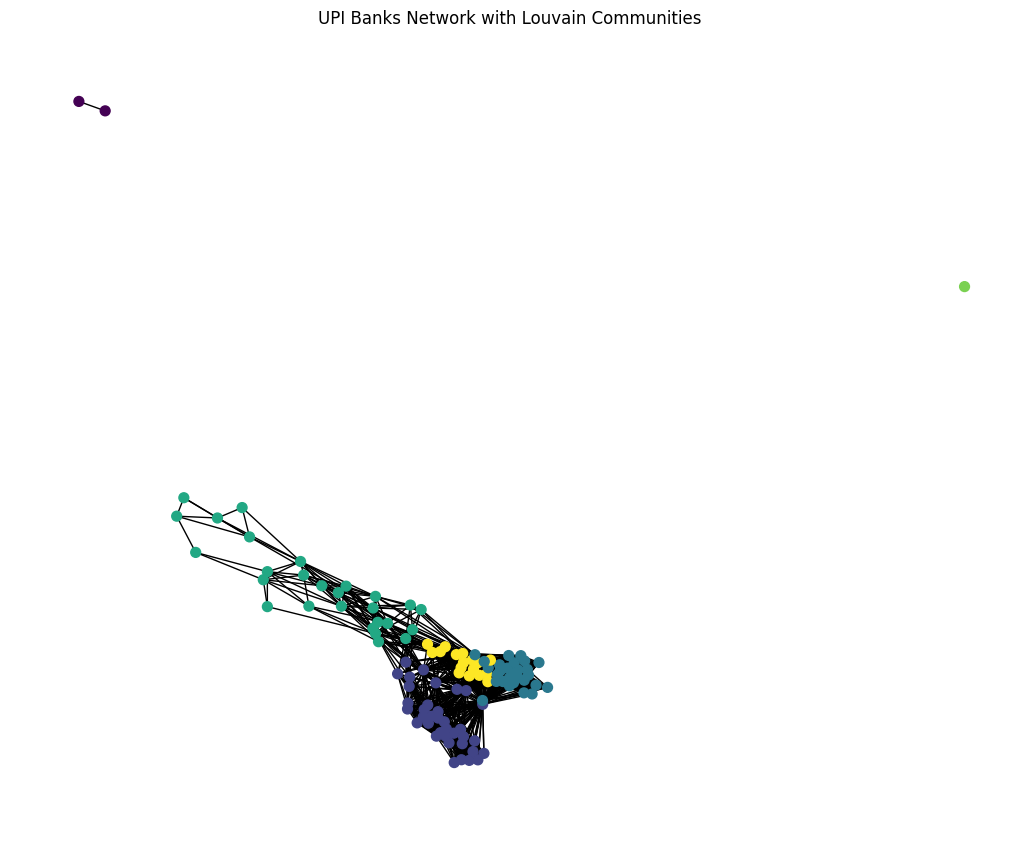

In [18]:
import pandas as pd
import networkx as nx
import networkx.readwrite as nx_rw  # Import readwrite submodule for gpickle
from community import community_louvain  # python-louvain library
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pickle  # Import pickle for fallback serialization

# Load the dataset from Colab's file system
file_path = '/content/sample_data/UPI apps transaction data in 2022 - - in 2022.csv.csv'  # Adjust path if needed
data = pd.read_csv(file_path)

# Clean column names by removing trailing newlines
data.columns = data.columns.str.strip()

# Define numerical and categorical features
numerical_features = [
    'Volume (Mn) By Costumers', 'Value (Cr) by Costumers',
    'Volume (Mn)', 'Value (Cr)', 'Month', 'Year'
]
categorical_features = ['UPI Banks']

# Convert numerical columns to numeric, handling commas
for col in numerical_features:
    data[col] = pd.to_numeric(data[col].replace(',', '', regex=True), errors='coerce')

# Handle missing values in numerical features
data[numerical_features] = data[numerical_features].fillna(data[numerical_features].median(numeric_only=True))

# Encode categorical feature (UPI Banks)
le = LabelEncoder()
data['UPI Banks_Encoded'] = le.fit_transform(data['UPI Banks'].astype(str))
label_encoders = {'UPI Banks': le}

# Create a network
G = nx.Graph()

# Add nodes (UPI Banks)
unique_banks = data['UPI Banks_Encoded'].unique()
G.add_nodes_from(unique_banks)

# Add edges based on transaction similarity in the same Month/Year
for i, row1 in data.iterrows():
    for j, row2 in data.iterrows():
        if row1['UPI Banks_Encoded'] < row2['UPI Banks_Encoded'] and row1['Month'] == row2['Month'] and row1['Year'] == row2['Year']:
            volume_diff = abs(row1['Volume (Mn)'] - row2['Volume (Mn)']) / max(row1['Volume (Mn)'], row2['Volume (Mn)'], 1)
            value_diff = abs(row1['Value (Cr)'] - row2['Value (Cr)']) / max(row1['Value (Cr)'], row2['Value (Cr)'], 1)
            similarity = 1 / (1 + volume_diff + value_diff)
            if similarity > 0.5:  # Threshold to reduce noise
                G.add_edge(row1['UPI Banks_Encoded'], row2['UPI Banks_Encoded'], weight=similarity)

# Apply Louvain Modularity for community detection
partition = community_louvain.best_partition(G, random_state=42)

# Analyze communities
community_counts = Counter(partition.values())
print("Number of communities:", len(community_counts))
print("Community sizes:", dict(community_counts))

# Add community labels to the dataset
data['Community'] = data['UPI Banks_Encoded'].map(partition)

# Identify potential anomalies (banks in small communities or with low degree)
degrees = dict(G.degree())
data['Degree'] = data['UPI Banks_Encoded'].map(degrees)
small_communities = [k for k, v in community_counts.items() if v < 3]  # Communities with <3 banks
anomalies = data[data['Community'].isin(small_communities) | (data['Degree'] < 2)]

# Decode UPI Banks for anomalies output
anomalies.loc[:, 'UPI Banks'] = label_encoders['UPI Banks'].inverse_transform(anomalies['UPI Banks_Encoded'])
print("\nPotential anomalies (banks in small communities or with low connectivity):")
print(anomalies[['UPI Banks', 'Community', 'Degree', 'Volume (Mn)', 'Value (Cr)']])

# Create a proxy label for evaluation (low Volume (Mn) as anomalies)
y_proxy = (data['Volume (Mn)'] < data['Volume (Mn)'].median()).astype(int)  # 1 for low volume, 0 otherwise
y_pred = (data['Community'].isin(small_communities) | (data['Degree'] < 2)).astype(int)

# Evaluate using proxy labels
print(f"\nROC AUC Score (using low volume as proxy for anomalies): {roc_auc_score(y_proxy, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_proxy, y_pred))

# Save the network and dataset with communities
try:
    nx_rw.write_gpickle(G, '/content/upi_network.gpickle')  # Try readwrite submodule
except AttributeError:
    # Fallback to pickle if write_gpickle is not available
    with open('/content/upi_network.gpickle', 'wb') as f:
        pickle.dump(G, f)
data['UPI Banks'] = label_encoders['UPI Banks'].inverse_transform(data['UPI Banks_Encoded'])
data.to_csv('/content/UPI_with_communities.csv', index=False)

# Visualize the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=list(partition.values()), cmap=plt.cm.viridis, with_labels=False, node_size=50)
plt.title("UPI Banks Network with Louvain Communities")
plt.savefig('/content/upi_network_communities.png')
plt.show()